Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1055 - loss: 3.0836 - val_accuracy: 0.4602 - val_loss: 2.0863
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4509 - loss: 1.9683 - val_accuracy: 0.7500 - val_loss: 1.2020
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6503 - loss: 1.2383 - val_accuracy: 0.7699 - val_loss: 0.8039
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7357 - loss: 0.8627 - val_accuracy: 0.8324 - val_loss: 0.5612
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8320 - loss: 0.6230 - val_accuracy: 0.8864 - val_loss: 0.3890
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8552 - loss: 0.4861 - val_accuracy: 0.9119 - val_loss: 0.3236
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8729 - loss: 0.4193 - val_accuracy: 0.9432 - val_loss: 0.2569
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8966 - loss: 0.3421 - val_accuracy: 0.9233 - 

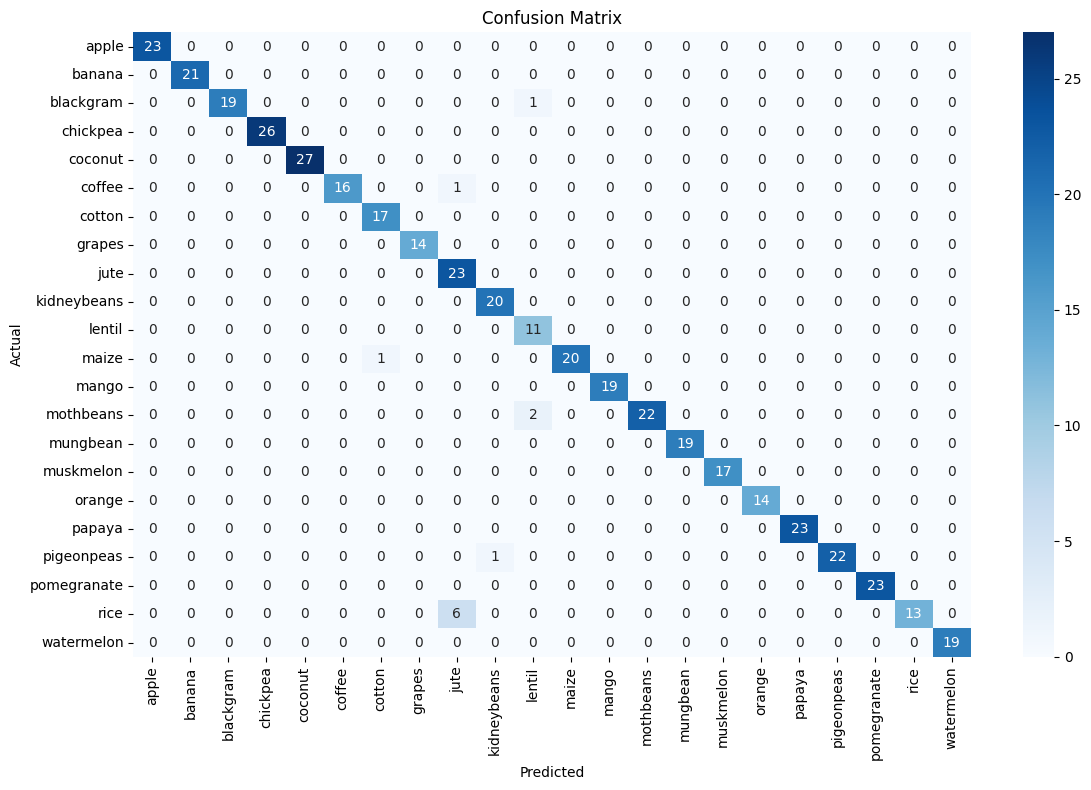

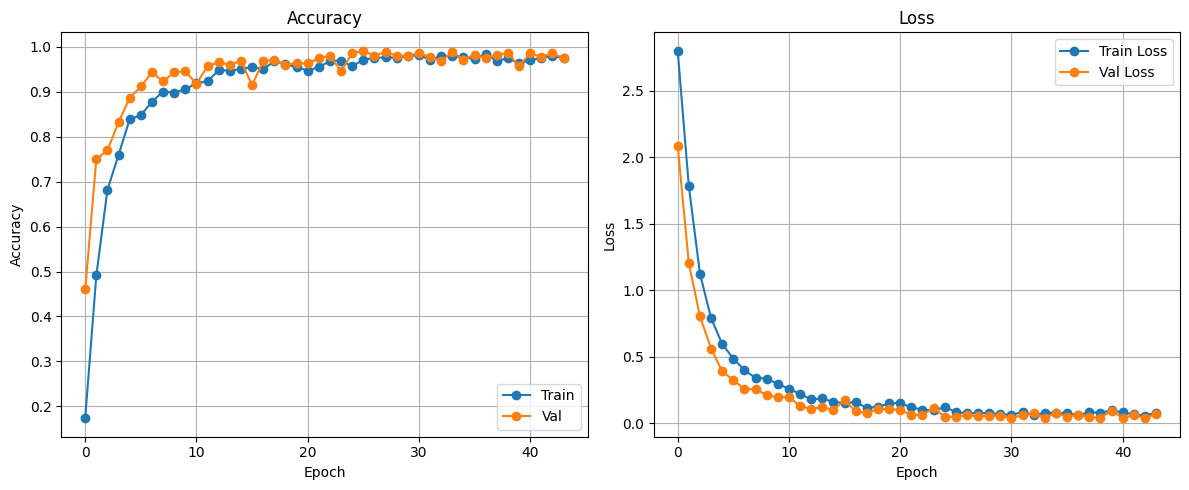

In [5]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Conv1D, GRU, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, features, 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# CrossTransformer: Cross-attention from learnable query to features
def crosstransformer(input_dim, num_features, num_classes, d_model=32, num_heads=4, ff_dim=64):
    inp = Input(shape=(num_features,))

    # Linear projection of features
    x = Dense(d_model)(inp)  # Shape: (batch, d_model)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    # Keys/values = projected feature embeddings
    kv = Dense(d_model)(inp)  # (batch, d_model)
    kv = Lambda(lambda x: tf.expand_dims(x, axis=1))(kv)
    # Cross-attention (query attends to features)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, kv)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = crosstransformer(input_dim=7, num_features=7, num_classes=y_cat.shape[1])  # or crosstransformer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop], verbose=1)

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 5. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 6. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

